# Object detection - Pascal VOC dataset

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
torch.cuda.set_device(0)

## Dataset: Pascal VOC

In [4]:
PATH = Path('data/pascal_voc//')

In [5]:
list(PATH.iterdir())

[PosixPath('data/pascal_voc/VOC2007'),
 PosixPath('data/pascal_voc/pascal_test2007.json'),
 PosixPath('data/pascal_voc/pascal_train2012.json'),
 PosixPath('data/pascal_voc/pascal_val2012.json'),
 PosixPath('data/pascal_voc/pascal_train2007.json'),
 PosixPath('data/pascal_voc/tmp'),
 PosixPath('data/pascal_voc/pascal_val2007.json'),
 PosixPath('data/pascal_voc/models')]

In [6]:
trn_json = json.load((PATH/'pascal_train2007.json').open())

In [7]:
trn_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [8]:
IMAGES, ANNOTATIONS, CATEGORIES = 'images', 'annotations', 'categories'  # so i can use tab to autocomplete

**Images:**

In [9]:
trn_json[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}]

**Bounding boxes:**

`bbox:` column and row of top left corner of bounding box, height and with of bounding box

`image_id:` to which image the bounding box belongs

`category_id:` category of the object in the bounding box

`iscrowd:` are there several objects of this category in the image?


In [10]:
trn_json[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

**Categories:**

In [11]:
trn_json[CATEGORIES][:5]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'}]

Let's put the categories, filenames and image ids in python dictionaries for convenience:

In [12]:
FN, ID, IMG_ID, CAT_ID, BBOX, NAME = 'file_name', 'id', 'image_id', 'category_id', 'bbox', 'name'

In [13]:
cats = dict((i[ID], i[NAME]) for i in trn_json[CATEGORIES])
trn_fns = dict((i[ID], i[FN]) for i in trn_json[IMAGES])
trn_ids = [i[ID] for i in trn_json[IMAGES]]

In [14]:
list((PATH/'VOC2007').iterdir())

[PosixPath('data/pascal_voc/VOC2007/ImageSets'),
 PosixPath('data/pascal_voc/VOC2007/JPEGImages'),
 PosixPath('data/pascal_voc/VOC2007/SegmentationClass'),
 PosixPath('data/pascal_voc/VOC2007/SegmentationObject'),
 PosixPath('data/pascal_voc/VOC2007/Annotations')]

In [15]:
JPEGS = 'VOC2007/JPEGImages'

In [16]:
IMPATH = PATH/JPEGS

In [17]:
list(IMPATH.iterdir())[:2]

[PosixPath('data/pascal_voc/VOC2007/JPEGImages/003034.jpg'),
 PosixPath('data/pascal_voc/VOC2007/JPEGImages/007859.jpg')]

**Let's create a dictionary that maps image ids to bounding boxes and classes:**

* `defaultdict` uses a default key for new entries
* switch x and y to be consistent with numpy
* convert top-left corner coordinates + height + width to top-left and bottom-right coordinates of the bounding boxes

In [18]:
trn_json[IMAGES][0][FN], trn_json[IMAGES][0][ID]

('000012.jpg', 12)

In [19]:
trn_json[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [20]:
def convert_bb_to_np(bb):
    return np.array([bb[1], bb[0], bb[1] + bb[3] - 1, bb[0] + bb[2] - 1])

def convert_bb_to_VOC(bb):
    return np.array([bb[1], bb[0], bb[3]-bb[1] + 1, bb[2]-bb[0] + 1])

In [21]:
# Let's quickly test it:
convert_bb_to_VOC(convert_bb_to_np([155, 96, 196, 174]))

array([155,  96, 196, 174])

In [22]:
trn_annotations = collections.defaultdict(lambda: [])

for o in trn_json[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = convert_bb_to_np(bb)
        trn_annotations[o[IMG_ID]].append((bb, o[CAT_ID]))

In [23]:
len(trn_annotations)

2501

**Let's check if everything went according to plan:**

In [24]:
trn_json[IMAGES][0]

{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}

In [25]:
trn_json[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [26]:
trn_annotations[12]

[(array([ 96, 155, 269, 350]), 7)]

In [27]:
cats[7]

'car'

## Let's look at some images and their bounding boxes

In [28]:
# using the new matplotlib API
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

Nice convenience function that creates white text/outlines with black backround or vice versa for better visibility:

In [29]:
def draw_outline(matplt_plot_obj, lw):
    matplt_plot_obj.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

In [30]:
def draw_rectangle(ax, bb):
    patch = ax.add_patch(patches.Rectangle(bb[:2], *bb[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [31]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [32]:
ex_img = trn_json[IMAGES][0]
im = open_image(IMPATH/ex_img[FN])
annos = trn_annotations[ex_img[ID]][0]

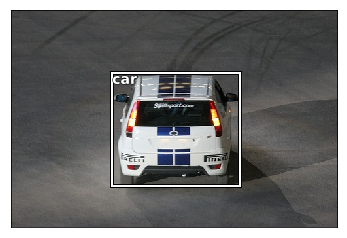

In [33]:
ax = show_img(im)
bb = convert_bb_to_VOC(annos[0])
draw_rectangle(ax, bb)
draw_text(ax, bb[:2], cats[annos[1]])

**However, what we want is a function that is only passed an index of a training input and that prints the respective  image and bounding boxes.**

In [34]:
def draw_image(im, annot):
    ax = show_img(im, figsize=(16,8))
    for bbox, cat in annot:
        bb = convert_bb_to_VOC(bbox)
        draw_rectangle(ax, bb)
        draw_text(ax, bb[:2], cats[cat], sz=16)

In [35]:
def draw_idx(i):
    im_annot = trn_annotations[i]
    im = open_image(IMPATH/trn_fns[i])
    print(im.shape)
    draw_image(im, im_annot)

(366, 500, 3)


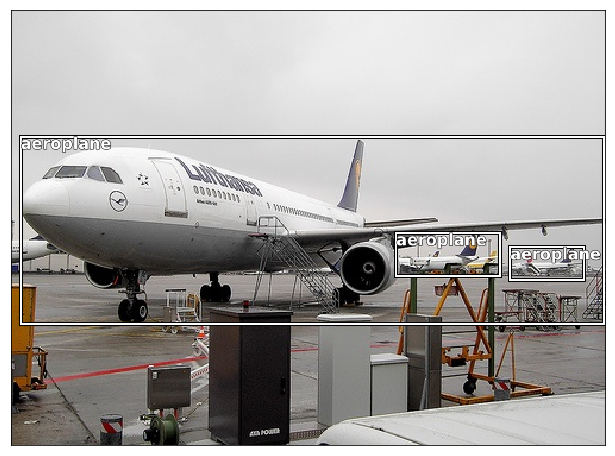

In [36]:
draw_idx(33)

## Step 1: Build a classifier that detects the *largest* object

First thing we need to do is convert the dict `trn_annotations` to a dict that only contains the largest bounding box:

In [37]:
# x[0] is the bounding box (x[1] would be the category)
# dot product calculates the area of the bounding box:
# x[0][-2:] - x[0][:2] is bottom right corner coords 
# minus top left corner coords. Result is np.array with
# width and height

def get_lrgst_bb(bb):
    if not bb:
        raise Exception()
    bb = sorted(bb, key=lambda x: np.product(x[0][-2:] - x[0][:2]), reverse=True)
    return bb[0]

In [38]:
nones = [i for i, bb in trn_annotations.items() if len(bb) == 0]

In [39]:
for n in nones:
    trn_annotations.pop(n)

In [40]:
trn_lrgst_annot = {key:get_lrgst_bb(item) for key, item in trn_annotations.items()}

**This dictionary contains the single largest bounding box (+ category) for every picture).**

In [41]:
bb, cat = trn_lrgst_annot[23]

In [42]:
bb = convert_bb_to_VOC(bb)

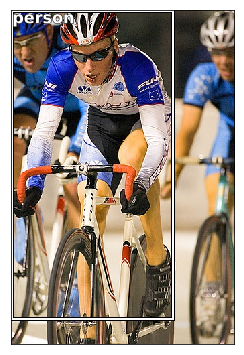

In [43]:
ax = show_img(open_image(IMPATH/trn_fns[23]),figsize=(4,8))
draw_rectangle(ax, bb)
draw_text(ax, bb[:2], cats[cat], sz=16)

**fast.ai already has the very handy `ImageClassifierData.from_csv`. Let's create a csv so that we can use it.**

In [44]:
(PATH/'tmp').mkdir(exist_ok=True)

In [45]:
CSV = PATH/'tmp/lrg.csv'

In [46]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'cat': [cats[trn_lrgst_annot[o][1]] for o in trn_ids]}, columns=['fn', 'cat'])

In [47]:
df.head(1)

,fn,cat
0,000012.jpg,car


In [48]:
trn_annotations[12]

[(array([ 96, 155, 269, 350]), 7)]

In [49]:
cats[7]

'car'

**Looks good**

In [50]:
df.to_csv(CSV, index=False)

In [51]:
first_model = resnet34
sz = 224
bs = 64

In [52]:
# we do not want to crop here so that we don't end
# up cutting away part of the largest object.
# CropType.NO means hat the picture is squished into 
# the square of size sz*sz instead of cropped.
tfms = tfms_from_model(first_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)

In [53]:
modeldata = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

In [54]:
x, y = next(iter(modeldata.trn_dl))

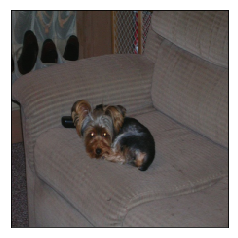

In [55]:
show_img(modeldata.val_ds.denorm(x.data.cpu().numpy())[2])

In [56]:
learn = ConvLearner.pretrained(first_model, modeldata, metrics=[accuracy])

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [57]:
learn.opt_fn = optim.Adam

In [58]:
lrf = learn.lr_find(start_lr=1e-5, end_lr=100)

 78%|███████▊  | 25/32 [00:03<00:01,  6.46it/s, loss=10.9]


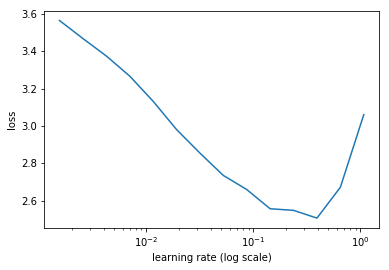

In [59]:
learn.sched.plot(n_skip=10, n_skip_end=0)

In [60]:
lr = 1e-2

In [61]:
learn.fit(lrs=lr, n_cycle=1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.277514   0.629279   0.798     



[0.6292793967723846, 0.7980000038146973]

In [62]:
lrs = np.array([lr/1000, lr/100, lr])

In [63]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:05<00:01,  4.98it/s, loss=3.99] 


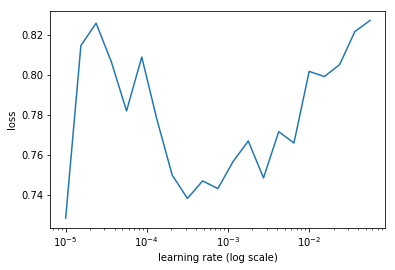

In [64]:
lrf = learn.lr_find(start_lr=lrs/1000)
learn.sched.plot(n_skip=0)

In [65]:
learn.fit(lrs=lrs/5, n_cycle=1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.80571    0.567692   0.816     



[0.5676915922164917, 0.8160000038146973]

In [66]:
learn.unfreeze()

In [67]:
learn.fit(lrs=lrs/5, n_cycle=1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.650112   0.549196   0.82      
    1      0.506469   0.526503   0.83                      



[0.5265026993751526, 0.8300000023841858]

**There are many objects of different categories in a typical image in this dataset. This might be the reason why the accuracy is not getting better.**

In [68]:
learn.save('first_model')

In [69]:
learn.load('first_model')

In [70]:
x, y = next(iter(modeldata.val_dl))

In [71]:
probs = F.softmax(predict_batch(learn.model, x), dim=-1)

In [72]:
x, preds = to_np(x), to_np(probs)

In [73]:
preds = np.argmax(preds, axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


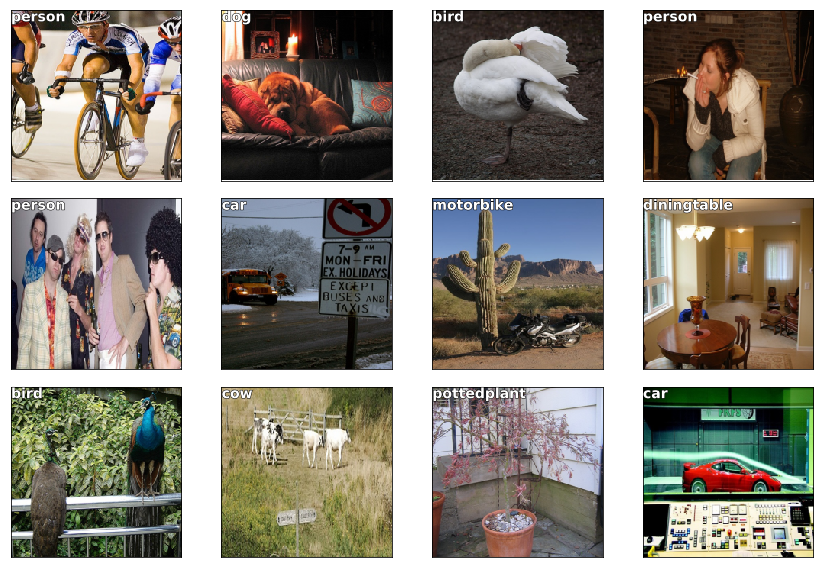

In [74]:
figure, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    im = modeldata.val_ds.denorm(x)[i]
    cat = modeldata.classes[preds[i]]
    ax = show_img(im, ax=ax)
    draw_text(ax, (0,0), cat)
plt.tight_layout()

## Step 2: Build a regressor for the bounding boxes

4 outputs: coordinates of top-left and bottom-right corner

In [75]:
BBOX_CSV = PATH/'tmp/bbox.csv'

In [76]:
bbox = np.array([trn_lrgst_annot[o][0] for o in trn_ids])

In [77]:
bbox = [' '.join(str(p) for p in o) for o in bbox]
# format ImageClassifierData.from_csv expects

In [78]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbox}, columns=['fn', 'bbox'])

In [79]:
df.head(2)

,fn,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,77 89 335 402


In [80]:
df.to_csv(BBOX_CSV, index=False)

In [81]:
# BBOX_CSV.open().readlines()[:5]

In [139]:
second_model = resnet34
sz = 224
bs = 64

**Problem: Our labels are coordinates that need to be transformed as well!**

In [140]:
augs = [RandomFlip(tfm_y=TfmType.COORD), 
        RandomRotate(3, p=0.5, tfm_y=TfmType.COORD), 
        RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD)]

In [141]:
tfms = tfms_from_model(second_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)

In [142]:
modeldata = ImageClassifierData.from_csv(PATH, JPEGS, BBOX_CSV, tfms=tfms, continuous=True, bs=4)

`continuous=True` tells the model that we aim to regress and not classify.

* labels won't be one-hot encoded
* criterion=MSE

[ 66.  38. 105. 183.]
[ 63.  34. 112. 189.]
[ 49.  35. 111. 188.]
[ 61.  35. 113. 188.]
[ 65.  37. 107. 185.]
[ 52.  38. 106. 183.]
[ 52.  38. 106. 183.]
[ 64.  36. 109. 186.]
[ 66.  38. 105. 183.]


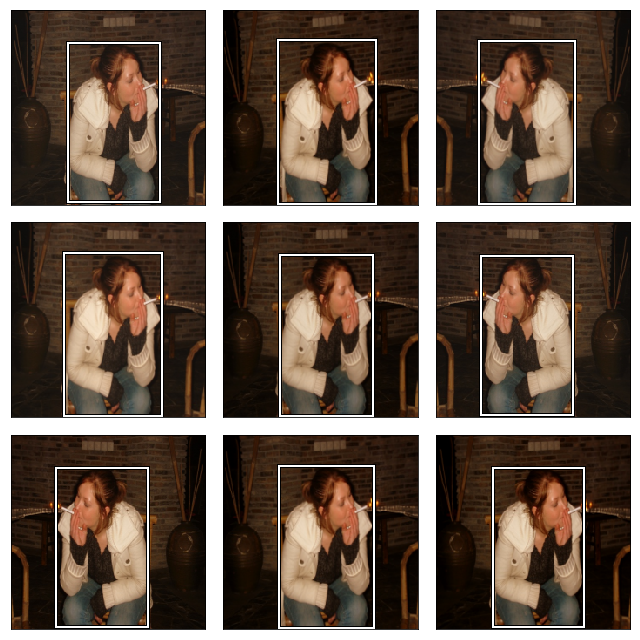

In [143]:
idx = 3
figure, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axes.flat):
    x, y = next(iter(modeldata.aug_dl))
    im = modeldata.val_ds.denorm(to_np(x))[idx]
    bb = convert_bb_to_VOC(to_np(y[idx]))
    print(bb)
    show_img(im, ax=ax)
    draw_rectangle(ax, bb)
plt.tight_layout()

Data augmentation and transformation of the labels/bounding boxes seems to work well.

We need to put a `custom_head` (fast.ai) ontop of the convnet:

* Adaptive pooling destroys the spatial information we need to regress the coordinates of the edges of the bounding boxes, we have to remove this layer.
* Final layer has 4 activations for the 4 needed coordinates of a bounding box.
* Linear activation function in the output layer, therefor MSE or L1 loss function.

\begin{equation}
L = \sum_i\left|y_i-\hat y_i\right|
\end{equation}

| L2 Loss | L1 Loss |
|---------------------|-----------------------------|
| Not very robust | Robust |
| Stable solution | Unstable solution |
| Always one solution | Possibly multiple solutions |

L2 penalizes deviations from the label stronger than L1 due to the square operation. L2 loss is therefore more sensitive to outliers and will adjust the model to minimize single outlier cases at the expense of the normal examples that have a much smaller error. 

[good resource](http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/)

`learn.summary()` reveals that the input to the `AdaptiveMaxPool2d` layer we will remove has the shape `[512, 7, 7]`.

In [144]:
head_regress_bb = nn.Sequential(Flatten(), nn.Linear(512 * 7 * 7, 4))

In [145]:
learn = ConvLearner.pretrained(second_model, modeldata, custom_head=head_regress_bb)

In [146]:
learn.opt_fn = optim.Adam

In [147]:
learn.crit = nn.L1Loss()

In [148]:
learn.lr_find(1e-5, 100)

 58%|█████▊    | 289/501 [00:05<00:03, 56.45it/s, loss=159] 


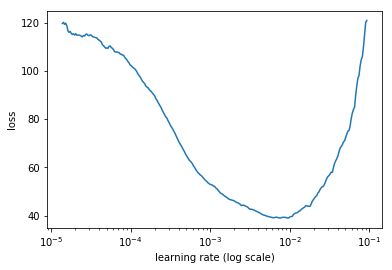

In [149]:
learn.sched.plot(10)

In [150]:
lr = 2e-3

In [151]:
learn.fit(lr, n_cycle=2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                              
    0      26.26519   26.841821 
    1      28.604872  28.902811                             
    2      22.777524  25.751352                             



[25.7513519821167]

In [152]:
lrs = np.array([lr/100, lr/10, lr])

In [154]:
learn.freeze_to(-2)

In [159]:
learn.fit(lrs, n_cycle=2, cycle_len=1, cycle_mult=2)

 26%|██▌       | 128/501 [00:04<00:11, 31.75it/s, loss=37.2]
epoch      trn_loss   val_loss                              
    0      25.380769  25.952786 
    1      27.565469  37.448154                             
    2      20.58305   21.991511                             



[21.9915114402771]

In [160]:
learn.freeze_to(-3)

In [161]:
learn.fit(lrs, n_cycle=1, cycle_len=2)

epoch      trn_loss   val_loss                              
    0      28.414685  29.149665 
    1      18.955355  21.708593                             



[21.708593299865722]

In [163]:
learn.save("regression_bbox")

In [164]:
learn.load("regression_bbox")

In [168]:
x, y = next(iter(modeldata.val_dl))
learn.model.eval()  # switches of dropbout and batchnorm
preds = learn.model(VV(x)).data.cpu().numpy()

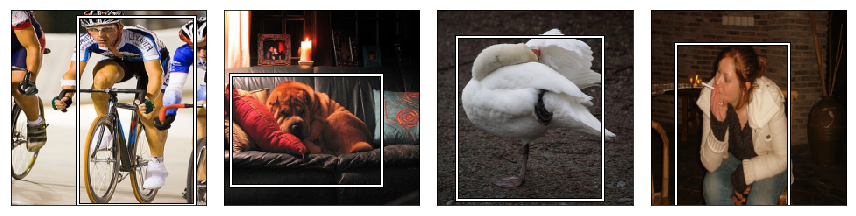

In [177]:
figure, axes = plt.subplots(1, 4, figsize=(12, 4))
for i, ax in enumerate(axes.flat):
    im = modeldata.val_ds.denorm(to_np(x))[i]
    bb = convert_bb_to_VOC(to_np(preds[i]))
    ax = show_img(im, ax=ax)
    draw_rectangle(ax, bb)
plt.tight_layout()

**Looks pretty good :)**